In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm.auto import tqdm
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.linear_model import LinearRegression

def event_occured(date, cutoff_date):
    if(date>=np.datetime64(cutoff_date)):
        return 1
    else:
        return 0

def days_from_event(x, cutoff_date):
    d1 = x
    d0 = datetime.datetime.strptime(cutoff_date,'%Y-%m-%d').date()
    delta = d1 - d0
    return delta.days

In [2]:
df_en = pd.read_pickle('balenciaga3.pkl')

### Step 1: Performing t-tests and analyzing peaks

The RDD window usually happens to be a 1-day one which makes us go from days to hours in terms of time intervals. This is an unreliable time interval since different news sources have press-releases at different times of the day. Thus, we were forced to set the intervals equal to 1 day.

To solve the issues above, we first detect the jumps using the t-tests. We construct the 2-sample t-test for every two days in a row and compare the brand perception metrics for these two days. In case we find that the t-statistic is significant, we mark the second day as the day with a jump. Figure 4 shows the graph of the t-statistic changes in time. The orange and the green lines represent the cut-offs, under which the t-statistic is insignificant. We set the cut-off to be symmetric and equal to 20 in order to filter 14 most outstanding PR moves or failures.

In [4]:
df_en['date'] = df_en['created_at'].apply(lambda x: x.date())
dates = sorted(df_en['date'].unique().tolist())

In [13]:
## compound is a the sentiment score
res = []

for i in tqdm(range(len(dates)-1)):
    date1 = dates[i]
    date2 = dates[i+1]
    
    df1 = df_en[df_en['date'] == date1]
    df2 = df_en[df_en['date'] == date2]
    
    res.append([date2, ttest_ind(df1['compound'], 
                                df2['compound'], equal_var=False)])
    
res_ = pd.DataFrame(res)
res_.columns = ['jump_date', 'test_results']
res_['t-stat'] = res_['test_results'].apply(lambda x: x[0])
res_['p-val'] = res_['test_results'].apply(lambda x: x[1])

  0%|          | 0/161 [00:00<?, ?it/s]

In [14]:
res_.head()

,jump_date,test_results,t-stat,p-val
0,2022-11-02,"(1.7907215588328418, 0.07348965289113579)",1.790722,0.073490
1,2022-11-03,"(-2.0146749621780637, 0.04399113727173747)",-2.014675,0.043991
2,2022-11-04,"(-4.412575583730974, 1.046427773573294e-05)",-4.412576,0.000010
3,2022-11-05,"(1.3843985574773754, 0.16632299332422834)",1.384399,0.166323
4,2022-11-06,"(0.6286552894394707, 0.5296120765065396)",0.628655,0.529612


<AxesSubplot:xlabel='jump_date', ylabel='t-stat'>

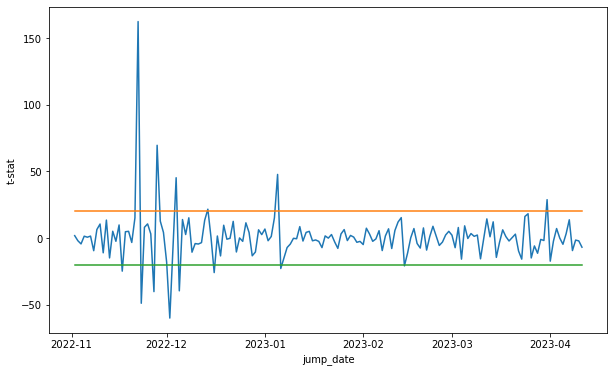

In [32]:
res_['line1'] = 20
res_['line2'] = -20

plt.figure(figsize=(10,6))

sns.lineplot(data=res_, x='jump_date', y='t-stat')
sns.lineplot(data=res_, x='jump_date', y='line1')
sns.lineplot(data=res_, x='jump_date', y='line2')

In [39]:
jump_dates = [datetime.date(2022, 11, 1)] + \
            res_[(res_['t-stat']>20)|(res_['t-stat']<-20)]['jump_date'].unique().tolist() + \
                [datetime.date(2023, 4, 10)]

In [45]:
df_en['created_at_date'] = df_en['created_at'].dt.date

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


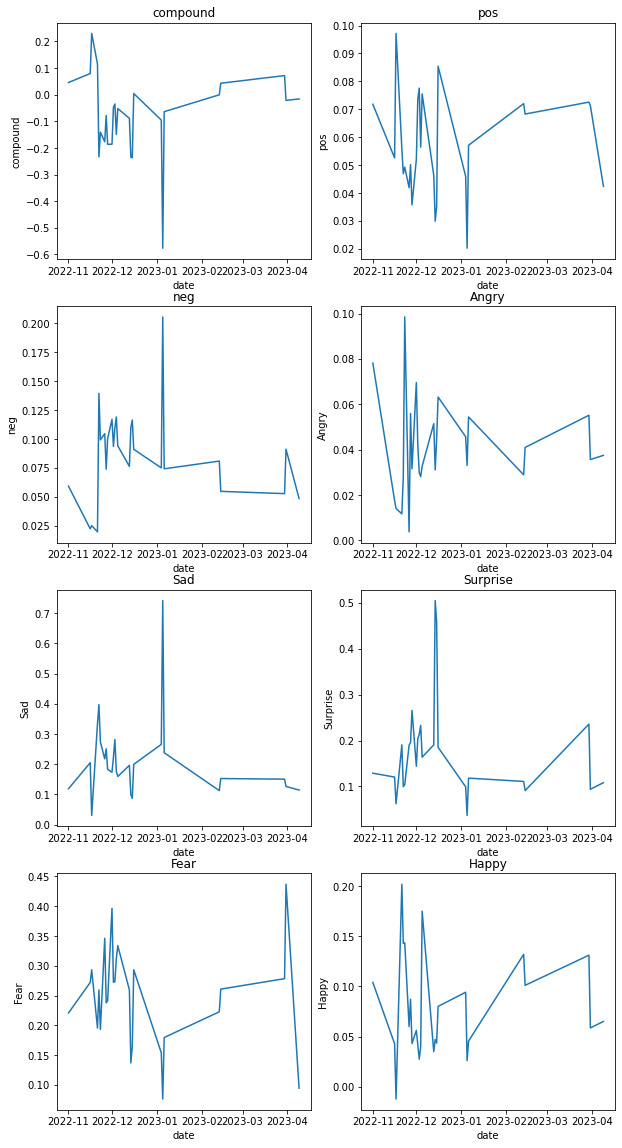

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [107]:
# creating a linear regression model for each sentiment score for each interval between events 

fig, axs = plt.subplots(4, 2, figsize=(10,20))
counter1 = 0
counter2 = 0

targets = ['compound', 'pos', 'neg', 'Angry', 'Sad', 'Surprise', 'Fear', 'Happy']

for target in targets:

    slopes = []

    for i in range(1, len(jump_dates)):
        date0 = jump_dates[i - 1]
        date1 = jump_dates[i]

        fin_df = df_en[(df_en['created_at_date'] < date1)&(df_en['created_at_date'] >= date0)]
    #     fin_df = fin_df[fin_df['neu']<0.5]
        dates = pd.DataFrame({'created_at_date':sorted(fin_df['created_at_date'].unique())}).reset_index()
        fin_df = fin_df.merge(dates, on = 'created_at_date')
        lr = LinearRegression()
        lr.fit(fin_df[['index']], fin_df[target])

        slopes.append([date0, date1, lr.coef_[0], lr.intercept_])

    slopes_ = pd.DataFrame(slopes)
    slopes_.columns = ['start', 'end', 'slope', 'intercept']

    dates = pd.DataFrame({'created_at_date':sorted(df_en['created_at_date'].unique())})

    for_graph = []

    for i in range(dates.shape[0]):
        for j in range(slopes_.shape[0]):
            if dates['created_at_date'][i] < slopes_['end'][j] and dates['created_at_date'][i] >= slopes_['start'][j]:
                diff = int(str(np.datetime64(dates['created_at_date'][i]) - \
                               np.datetime64(slopes_['start'][j])).replace(' days', ''))
                y = slopes_['slope'][j] * diff + slopes_['intercept'][j]
                for_graph.append([dates['created_at_date'][i], y])

    for_graph = pd.DataFrame(for_graph)
    for_graph.columns = ['date', target]

    plt.figure(figsize=(10,6))

    sns.lineplot(data=for_graph, x='date', y=target, ax = axs[counter1][counter2])
    axs[counter1][counter2].set_title(target)
    print(counter1, counter2)
    
    counter2 += 1
    
    if counter2 == 2:
        counter1 += 1
        counter2 = 0
        
# plt.show()
fig.savefig('Interval Analysis.jpg')

For the cases where we are able to construct a window greater than 2 days, we use the RDD design to get more information not only about the difference in means, but also about the differences in the regressions’ slope coefficients with an estimate of statistical significance. We cannot take the amount of days equal to 2 or less, because we get into the case of matrix singularity in terms of days, while the hour time interval is unreliable

Below we are calculating slope coefficients for each emotion, 

In [112]:
indices = [1, 6, 13, 14]

for cutoff_index in indices:
    fin_df = df_en.copy()

    date0 = jump_dates[cutoff_index - 1]
    date1 = jump_dates[cutoff_index]
    date2 = jump_dates[cutoff_index + 1]
    
    days1 = int(str(np.datetime64(date1) - np.datetime64(date0)).replace(' days', ''))
    days2 = int(str(np.datetime64(date2) - np.datetime64(date1)).replace(' days', ''))

    window = min(days1, days2)

    fin_df = fin_df[(fin_df['created_at_date']>np.datetime64(date0))&
                    (fin_df['created_at_date']<np.datetime64(date2))]

    fin_df['after_event'] = fin_df.apply(lambda x: event_occured(x['created_at_date'], str(date1)), axis = 1)
    fin_df['days_from_event'] = fin_df.apply(lambda x: days_from_event(x['created_at_date'], str(date1)), axis = 1)
    
    fin_df['after_event'] = fin_df.apply(lambda x: event_occured(x['created_at_date'], str(date1)), axis = 1)
    fin_df['days_from_event'] = fin_df.apply(lambda x: days_from_event(x['created_at_date'], str(date1)), axis = 1)
    
    reg_df = fin_df[(fin_df['days_from_event'] >= -window)
                &(fin_df['days_from_event'] <= window)]

    for target in ['compound', 'neg', 'pos', 'Angry', 'Sad', 'Surprise', 'Fear', 'Happy']:

        result = smf.ols(formula = f"{target} ~ days_from_event + after_event + after_event * days_from_event", 
                         data = reg_df).fit()
        print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     451.0
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          6.80e-291
Time:                        18:28:41   Log-Likelihood:                -20173.
No. Observations:               89696   AIC:                         4.035e+04
Df Residuals:                   89692   BIC:                         4.039e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               Surprise   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     517.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:28:42   Log-Likelihood:                -22801.
No. Observations:               89696   AIC:                         4.561e+04
Df Residuals:                   89692   BIC:                         4.565e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                    neg   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     908.6
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:30:17   Log-Likelihood:             3.1877e+05
No. Observations:              380462   AIC:                        -6.375e+05
Df Residuals:                  380458   BIC:                        -6.375e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               Surprise   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     192.7
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          7.31e-125
Time:                        18:30:17   Log-Likelihood:                -90634.
No. Observations:              380462   AIC:                         1.813e+05
Df Residuals:                  380458   BIC:                         1.813e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                    pos   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     139.9
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.68e-90
Time:                        18:31:03   Log-Likelihood:             1.1705e+05
No. Observations:              134489   AIC:                        -2.341e+05
Df Residuals:                  134485   BIC:                        -2.340e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     298.6
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          3.50e-192
Time:                        18:31:42   Log-Likelihood:                -24582.
No. Observations:               50341   AIC:                         4.917e+04
Df Residuals:                   50337   BIC:                         4.921e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               Surprise   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2602.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:31:42   Log-Likelihood:                -11971.
No. Observations:               50341   AIC:                         2.395e+04
Df Residuals:                   50337   BIC:                         2.398e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [113]:
fin_df.columns

Index(['tweet_id', 'text', 'author_id', 'geo', 'created_at', 'lang',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'author_location', 'country', 'query', 'username', 'location', 'name',
       'country2', 'neg', 'neu', 'pos', 'compound', 'Happy', 'Angry',
       'Surprise', 'Sad', 'Fear', 'date', 'created_at_date', 'after_event',
       'days_from_event'],
      dtype='object')

In [114]:
## Adding covariates
indices = [1, 6, 13, 14]

for cutoff_index in indices:
    fin_df = df_en.copy()

    date0 = jump_dates[cutoff_index - 1]
    date1 = jump_dates[cutoff_index]
    date2 = jump_dates[cutoff_index + 1]
    
    days1 = int(str(np.datetime64(date1) - np.datetime64(date0)).replace(' days', ''))
    days2 = int(str(np.datetime64(date2) - np.datetime64(date1)).replace(' days', ''))

    window = min(days1, days2)

    fin_df = fin_df[(fin_df['created_at_date']>np.datetime64(date0))&
                    (fin_df['created_at_date']<np.datetime64(date2))]

    fin_df['after_event'] = fin_df.apply(lambda x: event_occured(x['created_at_date'], str(date1)), axis = 1)
    fin_df['days_from_event'] = fin_df.apply(lambda x: days_from_event(x['created_at_date'], str(date1)), axis = 1)
    
    fin_df['after_event'] = fin_df.apply(lambda x: event_occured(x['created_at_date'], str(date1)), axis = 1)
    fin_df['days_from_event'] = fin_df.apply(lambda x: days_from_event(x['created_at_date'], str(date1)), axis = 1)
    
    reg_df = fin_df[(fin_df['days_from_event'] >= -window)
                &(fin_df['days_from_event'] <= window)]

    for target in ['compound', 'neg', 'pos', 'Angry', 'Sad', 'Surprise', 'Fear', 'Happy']:

        result = smf.ols(formula = f"{target} ~ days_from_event + after_event + after_event * days_from_event + retweet_count + reply_count + like_count + quote_count", 
                         data = reg_df).fit()
        print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     3128.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:33:26   Log-Likelihood:                -11048.
No. Observations:               89696   AIC:                         2.211e+04
Df Residuals:                   89688   BIC:                         2.219e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                    Sad   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     4287.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:33:26   Log-Likelihood:                 5379.9
No. Observations:               89696   AIC:                        -1.074e+04
Df Residuals:                   89688   BIC:                        -1.067e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1964.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:35:02   Log-Likelihood:            -1.8842e+05
No. Observations:              380462   AIC:                         3.769e+05
Df Residuals:                  380454   BIC:                         3.769e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                    Sad   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3441.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:35:04   Log-Likelihood:                -66074.
No. Observations:              380462   AIC:                         1.322e+05
Df Residuals:                  380454   BIC:                         1.323e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     500.6
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:35:50   Log-Likelihood:                -70939.
No. Observations:              134489   AIC:                         1.419e+05
Df Residuals:                  134481   BIC:                         1.420e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:               Surprise   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     475.5
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:35:51   Log-Likelihood:                -23894.
No. Observations:              134489   AIC:                         4.780e+04
Df Residuals:                  134481   BIC:                         4.788e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                  Angry   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     82.69
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          4.41e-120
Time:                        18:36:30   Log-Likelihood:                 17861.
No. Observations:               50341   AIC:                        -3.571e+04
Df Residuals:                   50333   BIC:                        -3.563e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [115]:
slopes_

,start,end,slope,intercept
0,2022-11-01,2022-11-17,-0.004078,0.104056
1,2022-11-17,2022-11-22,0.053575,-0.012284
2,2022-11-22,2022-11-23,0.000000,0.142909
3,2022-11-23,2022-11-27,-0.027823,0.143518
4,2022-11-27,2022-11-28,0.000000,0.087245
5,2022-11-28,2022-12-02,0.004347,0.043131
6,2022-12-02,2022-12-04,-0.014309,0.041802
7,2022-12-04,2022-12-05,0.000000,0.039749
8,2022-12-05,2022-12-14,-0.017526,0.175185
9,2022-12-14,2022-12-16,-0.003608,0.047129
